
1 (Positive Class): Represents patients who were diagnosed with metastatic cancer within 90 days of screening.
0 (Negative Class): Represents patients who were not diagnosed with metastatic cancer within 90 days of screening



In [1]:
!pip install tabulate

In [2]:
!pip install imbalanced-learn


# Step 1: Load essential libraries

In [3]:
# prompt: auto EDA libraries in python like Sweetviz?
import pandas as pd

# standard libraries
import pandas as pd
import numpy as np
import os
from google.colab import drive
drive.mount('/content/drive')

# ML/stats
from mlxtend.plotting import heatmap
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# for splitting the data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler



# visualizations
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import plotly.express as px
from tabulate import tabulate


%matplotlib inline

# tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


Mounted at /content/drive


# 2. Step 2: Read the data

In [4]:
path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Train/'
train_df = pd.read_csv(path + 'training.csv')
print(train_df.head())

test_path = '/content/drive/MyDrive/WIDS-Datathon-2024/Data/Test/'
test_df = pd.read_csv(test_path + 'test.csv')
print(test_df.head())


   patient_id patient_race  payer_type patient_state  patient_zip3  \
0      475714          NaN    MEDICAID            CA           924   
1      349367        White  COMMERCIAL            CA           928   
2      138632        White  COMMERCIAL            TX           760   
3      617843        White  COMMERCIAL            CA           926   
4      817482          NaN  COMMERCIAL            ID           836   

   patient_age patient_gender    bmi breast_cancer_diagnosis_code  \
0           84              F    NaN                       C50919   
1           62              F  28.49                       C50411   
2           43              F  38.09                       C50112   
3           45              F    NaN                       C50212   
4           55              F    NaN                         1749   

                        breast_cancer_diagnosis_desc  ...   disabled  \
0  Malignant neoplasm of unsp site of unspecified...  ...  12.871429   
1  Malig neoplm of u

In [7]:
#shape of data
print(train_df.shape)
print(test_df.shape)
test_df.columns

(12906, 83)
(5792, 82)


Index(['patient_id', 'patient_race', 'payer_type', 'patient_state',
       'patient_zip3', 'patient_age', 'patient_gender', 'bmi',
       'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc',
       'metastatic_cancer_diagnosis_code', 'metastatic_first_novel_treatment',
       'metastatic_first_novel_treatment_type', 'Region', 'Division',
       'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19',
       'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s',
       'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married',
       'widowed', 'family_size', 'family_dual_income',
       'income_household_median', 'income_household_under_5',
       'income_household_5_to_10', 'income_household_10_to_15',
       'income_household_15_to_20', 'income_household_20_to_25',
       'income_household_25_to_35', 'income_household_35_to_50',
       'income_household_50_to_75', 'income_household_75_to_100',
       'income_household_100_to_150', 'in

# step 3: Compute missing value percentage of each of the columns





In [8]:

def calculate_missing_data_percentage(df):
    """
    Calculate and print the percentage of missing data for each column in the DataFrame,
    sorted in descending order, in a pretty table format.

    Parameters:
    df (DataFrame): The DataFrame for which to calculate missing data percentages.
    """
    # Calculate the percentage of missing data for each column
    percent_nulls = df.isnull().sum() / len(df) * 100

    # Sort the results in descending order and filter out columns with no missing data
    missing_data_columns = percent_nulls[percent_nulls > 0].sort_values(ascending=False)

    # Check if there are any missing data columns
    if missing_data_columns.empty:
        print("No missing data found in the DataFrame.")
    else:
        print("Percentage of missing data per column (sorted in descending order):")
        # Convert the Series to a DataFrame for pretty printing
        missing_data_df = missing_data_columns.reset_index()
        missing_data_df.columns = ['Column', 'Percentage Missing']
        # Print using tabulate
        print(tabulate(missing_data_df, headers='keys', tablefmt='pretty', showindex=False))

calculate_missing_data_percentage(train_df)


Percentage of missing data per column (sorted in descending order):
+---------------------------------------+----------------------+
|                Column                 |  Percentage Missing  |
+---------------------------------------+----------------------+
|   metastatic_first_novel_treatment    |  99.81403998140401   |
| metastatic_first_novel_treatment_type |  99.81403998140401   |
|                  bmi                  |  69.46381527971485   |
|             patient_race              |  49.47311328064466   |
|              payer_type               |  13.97024639702464   |
|                Region                 | 0.40291337362467067  |
|               Division                | 0.40291337362467067  |
|             patient_state             | 0.39516503951650395  |
|                 PM25                  |  0.2247016891368356  |
|                 Ozone                 |  0.2247016891368356  |
|                  N02                  |  0.2247016891368356  |
|      income_househol

# step 4: Drop columns that have more than 50% null values in them


In [9]:
# prompt: drop bmi, metastatic_first_novel_treatment and metastatic_first_novel_treatment_type columns

train_df.drop(columns=['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1, inplace=True)
test_df.drop(columns=['bmi', 'metastatic_first_novel_treatment', 'metastatic_first_novel_treatment_type'], axis=1, inplace=True)


In [10]:
print(train_df.shape)

(12906, 80)


In [11]:
from sklearn.model_selection import train_test_split
import pandas as pd

def split_train_validation(df, target_column, test_size=0.2, random_state=42):
    """
    Splits the DataFrame into training and validation sets, ensuring that both classes
    are represented in proportion to the original dataset.

    Parameters:
    df (pd.DataFrame): The DataFrame to be split.
    target_column (str): The name of the target variable column.
    test_size (float): The proportion of the dataset to include in the validation set.
    random_state (int): A seed value to ensure reproducibility.

    Returns:
    pd.DataFrame, pd.DataFrame: The training and validation DataFrames.
    """
    # Split the data into X (features) and y (target)
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Split the data into training and validation sets with stratification
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Combine X and y into single DataFrames for train and validation
    train_df = pd.concat([X_train, y_train], axis=1)
    val_df = pd.concat([X_val, y_val], axis=1)

    return train_df, val_df

# Usage:
train_df, val_df = split_train_validation(train_df, 'DiagPeriodL90D')

# You can check the distribution in each set, for example:
print(train_df['DiagPeriodL90D'].value_counts())
print(val_df['DiagPeriodL90D'].value_counts())

1    6448
0    3876
Name: DiagPeriodL90D, dtype: int64
1    1612
0     970
Name: DiagPeriodL90D, dtype: int64


In [6]:
split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/'

def save_train_val_csv(train_df, val_df, split_path):
    """
    Saves the training and validation DataFrames to CSV files.

    Parameters:
    train_df (pd.DataFrame): The training DataFrame.
    val_df (pd.DataFrame): The validation DataFrame.
    split_path (str): The file path where the CSV files will be saved.
    """
    train_file_path = split_path + "train_set.csv"
    val_file_path = split_path + "val_set.csv"

    # Save the DataFrames to CSV
    train_df.to_csv(train_file_path, index=False)
    val_df.to_csv(val_file_path, index=False)

    print(f"Training data saved to {train_file_path}")
    print(f"Validation data saved to {val_file_path}")

# Usage example:
# Assuming train_df and val_df are already defined
save_train_val_csv(train_df, val_df, split_path)


NameError: name 'val_df' is not defined

In [12]:
split_path = '/content/drive/MyDrive/WIDS-Datathon-2024/split/'

train_df = pd.read_csv(split_path + 'train_set.csv')
val_df = pd.read_csv(split_path + 'val_set.csv')
print(train_df.shape)
print(val_df.shape)

(10324, 80)
(2582, 80)


Step 5: Check the datatypes of every column and split the categorical and the numerical columns

In [13]:
#get the datatypes of all columns
data_types = train_df.dtypes
categorical_cols = data_types[data_types == 'object'].index.tolist()
categorical_cols = train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify numerical columns
numerical_cols = data_types[data_types.isin(['int64', 'float64'])].index.tolist()
# Alternate method
numerical_cols = train_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)


Categorical columns: ['patient_race', 'payer_type', 'patient_state', 'patient_gender', 'breast_cancer_diagnosis_code', 'breast_cancer_diagnosis_desc', 'metastatic_cancer_diagnosis_code', 'Region', 'Division']
Numerical columns: ['patient_id', 'patient_zip3', 'patient_age', 'population', 'density', 'age_median', 'age_under_10', 'age_10_to_19', 'age_20s', 'age_30s', 'age_40s', 'age_50s', 'age_60s', 'age_70s', 'age_over_80', 'male', 'female', 'married', 'divorced', 'never_married', 'widowed', 'family_size', 'family_dual_income', 'income_household_median', 'income_household_under_5', 'income_household_5_to_10', 'income_household_10_to_15', 'income_household_15_to_20', 'income_household_20_to_25', 'income_household_25_to_35', 'income_household_35_to_50', 'income_household_50_to_75', 'income_household_75_to_100', 'income_household_100_to_150', 'income_household_150_over', 'income_household_six_figure', 'income_individual_median', 'home_ownership', 'housing_units', 'home_value', 'rent_median'

# step 5 Downsampling

In [14]:
def apply_random_undersampling(df, target_column):
    """
    Applies random undersampling to balance class distribution in the DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to be undersampled.
    target_column (str): The name of the target variable column.

    Returns:
    pd.DataFrame: A new DataFrame with balanced class distribution.
    """
    # Initialize the RandomUnderSampler
    rus = RandomUnderSampler(random_state=42)

    # Separate features and target variable
    X = df.drop(target_column, axis=1)
    y = df[target_column]

    # Perform undersampling
    X_res, y_res = rus.fit_resample(X, y)

    # Creating a new DataFrame from the undersampled data
    df_resampled = pd.DataFrame(X_res, columns=X.columns)
    df_resampled[target_column] = y_res

    return df_resampled

# Usage:
train_df_resampled = apply_random_undersampling(train_df, 'DiagPeriodL90D')

# Check new class distribution
print(train_df_resampled['DiagPeriodL90D'].value_counts())


0    3876
1    3876
Name: DiagPeriodL90D, dtype: int64


In [15]:
# Check new class distribution on val and test df
print(val_df['DiagPeriodL90D'].value_counts())

1    1612
0     970
Name: DiagPeriodL90D, dtype: int64


#step 6: Impute categorical variables using mode and continuous variable using mean of train dataset and apply the same to the test dataset

In [16]:

def calculate_imputation_values(df, categorical_cols, numerical_cols, target_variable, patient_id):
    """
    Calculates imputation values (mean and mode) for numerical and categorical columns respectively.

    Parameters:
    df (pd.DataFrame): The DataFrame to calculate values from.
    categorical_cols (list): List of categorical column names.
    numerical_cols (list): List of numerical column names.
    target_variable (str): The name of the target variable column.
    patient_id (str): The patient identifier column.

    Returns:
    dict: A dictionary containing imputation values for each column.
    """
    imputation_values = {}
    for col in categorical_cols:
        if col != target_variable:
            imputation_values[col] = df[col].mode()[0]

    for col in numerical_cols:
        if col != target_variable and col != patient_id:
            imputation_values[col] = df[col].mean()

    return imputation_values


def apply_imputation(df, imputation_values):
    """
    Applies imputation values to a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to impute.
    imputation_values (dict): Dictionary containing imputation values for each column.

    Returns:
    pd.DataFrame: The imputed DataFrame.
    """
    for col, value in imputation_values.items():
        df[col].fillna(value, inplace=True)

    return df


# Usage
# First, calculate imputation values from the training data
imputation_values = calculate_imputation_values(train_df_resampled, categorical_cols, numerical_cols, 'DiagPeriodL90D', 'patient_id')

# Apply imputation to training data
train_df_imputed = apply_imputation(train_df_resampled, imputation_values)

# Apply the same imputation to test data
test_df_imputed = apply_imputation(test_df, imputation_values)

# Apply the validation imputation to test data
val_df_imputed = apply_imputation(val_df, imputation_values)


In [17]:
print(train_df_imputed.shape)
print(test_df_imputed.shape)
print(val_df_imputed.shape)

(7752, 80)
(5792, 79)
(2582, 80)


#step 7: Check if there are missing values after imputation

In [18]:
def check_missing_values(df):
    """
    Checks for missing values in a pandas DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to check for missing values.

    Prints:
    str: A message indicating whether missing values are found and details if there are any.
    """
    missing_values_after_imputation = df.isna().sum()
    missing_values = missing_values_after_imputation[missing_values_after_imputation > 0]

    if missing_values.empty:
        print("No missing values found after imputation.")
    else:
        print("Missing values remaining after imputation:")
        print(missing_values)

# Usage:
check_missing_values(train_df_imputed)
check_missing_values(test_df_imputed)
check_missing_values(val_df_imputed)


No missing values found after imputation.
No missing values found after imputation.
No missing values found after imputation.


Scale continuous variables

In [19]:
def scale_continuous_features(train_df, val_df, continuous_columns):
    # Initialize the MinMaxScaler for continuous variables
    scaler = MinMaxScaler((0, 1)).fit(train_df[continuous_columns])

    # Normalize the continuous variables separately
    train_df[continuous_columns] = scaler.transform(train_df[continuous_columns])
    val_df[continuous_columns] =  scaler.transform(val_df[continuous_columns])
    #test_df[continuous_columns] = scaler.transform(val_df[continuous_columns])
    return train_df, val_df
scale_continuous_features(train_df_imputed,val_df_imputed, numerical_cols)

(      patient_id patient_race          payer_type patient_state  patient_zip3  \
 0       0.517488        White          COMMERCIAL            KY      0.336313   
 1       0.023672        White            MEDICAID            AZ      0.842458   
 2       0.954727        Black          COMMERCIAL            KY      0.362011   
 3       0.622777        White          COMMERCIAL            TX      0.745251   
 4       0.730937     Hispanic            MEDICAID            CA      0.921788   
 ...          ...          ...                 ...           ...           ...   
 7747    0.049387     Hispanic          COMMERCIAL            TX      0.750838   
 7748    0.200266        White            MEDICAID            TN      0.299441   
 7749    0.613236        Black  MEDICARE ADVANTAGE            MS      0.320670   
 7750    0.378049        White  MEDICARE ADVANTAGE            MI      0.435754   
 7751    0.640722        White          COMMERCIAL            MO      0.601117   
 
       patient

In [20]:
def find_unseen_categories(train_df, val_df, categorical_cols):
    unseen_categories = {}
    for col in categorical_cols:
        train_categories = set(train_df[col].dropna().unique())
        val_categories = set(val_df[col].dropna().unique())

        # Find categories present in validation but not in training
        unseen = val_categories - train_categories

        if unseen:
            unseen_categories[col] = unseen

    return unseen_categories

# Usage
unseen_categories_in_val = find_unseen_categories(train_df_imputed, val_df_imputed, categorical_cols)
unseen_categories_in_val

{'patient_state': {'CT', 'PR'},
 'breast_cancer_diagnosis_code': {'1759', 'C5001'},
 'breast_cancer_diagnosis_desc': {'Malignant neoplasm of nipple and areola, female',
  'Malignant neoplasm of other and unspecified sites of male breast'},
 'metastatic_cancer_diagnosis_code': {'C7910', 'C7962'}}

In [21]:
train_df_imputed['patient_state'].unique()

array(['KY', 'AZ', 'TX', 'CA', 'OH', 'VA', 'IL', 'GA', 'NY', 'CO', 'NM',
       'OK', 'PA', 'IA', 'ID', 'LA', 'MI', 'MN', 'IN', 'WA', 'NV', 'WI',
       'MO', 'OR', 'FL', 'SC', 'DE', 'NC', 'AL', 'KS', 'MS', 'UT', 'MD',
       'WY', 'MT', 'WV', 'AR', 'TN', 'NE', 'NJ', 'HI', 'ND', 'DC', 'SD',
       'AK', 'NH', 'RI'], dtype=object)

#step 8 Perform One hot encoding on Categorical Columns

In [22]:
def preprocess_data(df, train_columns, categorical_columns):
    # Convert "patient_gender" to binary (F as 1 and M as 0)
    df["patient_gender"] = df["patient_gender"].apply(lambda x: 1 if x == "F" else 0)

    # One-hot encode the categorical variables
    df_encoded = pd.get_dummies(df, columns=categorical_columns)

    # If train_columns is provided, align the columns
    if train_columns is not None:
        # Add missing columns (that were in training but not in validation) with zeros
        for col in set(train_columns) - set(df_encoded.columns):
            df_encoded[col] = 0

        # Drop extra columns (that are in validation but not in training)
        extra_cols = set(df_encoded.columns) - set(train_columns)
        df_encoded = df_encoded.drop(columns=extra_cols, errors='ignore')

        # Reorder columns to match the training data
        df_encoded = df_encoded.reindex(columns=train_columns, fill_value=0)

    return df_encoded

In [23]:
# Apply preprocessing to the training dataset
train_df_encoded = preprocess_data(train_df_imputed, None, categorical_cols)
train_columns = train_df_encoded.columns

# Apply preprocessing to the validation dataset
val_df_encoded = preprocess_data(val_df_imputed, train_columns, categorical_cols)


In [24]:
print(train_df_encoded.shape)
print(val_df_encoded.shape)

(7752, 275)
(2582, 275)


#Step 9 Split into

In [25]:
def split_features_target(df, target_column_name):
    # Keep a copy of patient_id before dropping it from features
    patient_id = df['patient_id']
    X = df.drop([target_column_name, 'patient_id'], axis=1)
    y = df[target_column_name]
    return X, y, patient_id

# Specify the name of the target column
target_column = "DiagPeriodL90D"

# Split train_df_encoded and val_df_encoded into features (X), target (y), and retain patient_id
train_x, train_y, train_patient_id = split_features_target(train_df_encoded, target_column)
val_x, val_y, val_patient_id = split_features_target(val_df_encoded, target_column)

In [26]:
#check shape
print(train_x.shape)
print(train_y.shape)

print(val_x.shape)
print(val_y.shape)


(7752, 273)
(7752,)
(2582, 273)
(2582,)


In [27]:
def build_model(input_features, learning_rate=0.0001):
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  tf.keras.backend.clear_session()
  model = tf.keras.Sequential()

  # Set input layer
  model.add(tf.keras.Input(shape=(input_features.shape[1],), name='Input'))

  # Add output layer for binary classification
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', name='Output'))

  # Compile model for binary classification
  model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])

  return model

In [28]:
def visualize(model_history):
  # visualize the loss and accuracy
  fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(15,5))

  axes[0].plot(model_history.history['loss'], color='purple', label='losses')
  axes[0].plot(model_history.history['val_loss'], color='orange', label='val_losses')
  axes[0].set_xlabel('Epoch')
  axes[0].set_ylabel('Loss')
  axes[0].set_title('Loss Progression')
  axes[0].legend()

  axes[1].plot(model_history.history['accuracy'], color='purple', label='accuracy')
  axes[1].plot(model_history.history['val_accuracy'], color='orange', label='val_accuracy')
  axes[1].set_xlabel('Epoch')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title('Accuracy Progression')
  axes[1].legend()
  plt.show()

Epoch 1/50
243/243 [==============================] - 3s 4ms/step - loss: 0.7032 - accuracy: 0.5018 - val_loss: 0.6992 - val_accuracy: 0.5066
Epoch 2/50
243/243 [==============================] - 1s 3ms/step - loss: 0.6900 - accuracy: 0.5366 - val_loss: 0.6856 - val_accuracy: 0.5531
Epoch 3/50
243/243 [==============================] - 1s 3ms/step - loss: 0.6812 - accuracy: 0.5730 - val_loss: 0.6776 - val_accuracy: 0.5875
Epoch 4/50
243/243 [==============================] - 1s 3ms/step - loss: 0.6729 - accuracy: 0.6080 - val_loss: 0.6680 - val_accuracy: 0.6290
Epoch 5/50
243/243 [==============================] - 1s 5ms/step - loss: 0.6651 - accuracy: 0.6397 - val_loss: 0.6598 - val_accuracy: 0.6619
Epoch 6/50
243/243 [==============================] - 1s 5ms/step - loss: 0.6576 - accuracy: 0.6649 - val_loss: 0.6549 - val_accuracy: 0.6758
Epoch 7/50
243/243 [==============================] - 2s 6ms/step - loss: 0.6503 - accuracy: 0.6854 - val_loss: 0.6495 - val_accuracy: 0.6894
Epoch 

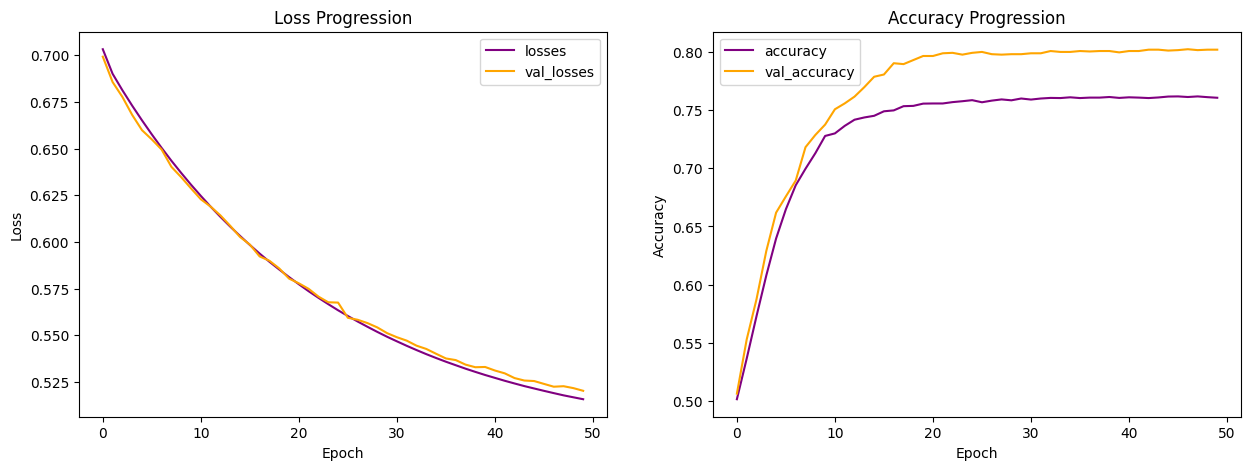

In [29]:
input_features = train_x
learning_rate = 0.0001

#Build the model
model = build_model(input_features, learning_rate)
history = model.fit(
   x=train_x,
   y=train_y,
   epochs=50,
   validation_data=(val_x, val_y),
   batch_size=32,
   verbose=1)

visualize(history)

In [30]:
train_results = {}
val_results = {}

In [31]:
train_yhat_probs = model.predict(train_x)
val_yhat_probs = model.predict(val_x)


81/81 [==============================] - 0s 3ms/step


In [32]:
# Create the submission DataFrame with probability scores
submission = pd.DataFrame({
    'patient_id': val_patient_id,
    'DiagPeriodL90D': val_y,   # True target values
    'prediction_probability': val_yhat_probs.flatten()  # Model's probability scores
})

result_path = '/content/drive/MyDrive/HS/'

# Save the submission DataFrame to a CSV file
submission.to_csv(result_path + 'submission.csv', index=False)

In [33]:
# predict using the training set
train_yhat_probs = model.predict(train_x)
# Assuming a threshold of 0.5 for classification
train_yhat_result = (train_yhat_probs > 0.5).astype(int)
train_yhat_result

243/243 [==============================] - 0s 1ms/step


array([[0],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]])

In [34]:
classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]

print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))


Training Classification Report

                              precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.92      0.57      0.71      3876
    Diagnosed within 90 Days       0.69      0.95      0.80      3876

                    accuracy                           0.76      7752
                   macro avg       0.81      0.76      0.75      7752
                weighted avg       0.81      0.76      0.75      7752



In [35]:
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import fbeta_score

# Assuming train_y and train_yhat_result are defined
classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]

# Print classification report
print('\nTraining Classification Report\n')
print(classification_report(train_y, train_yhat_result, target_names=classes))

# Calculate and print F2 score
# Note: beta > 1 favors recall (beta = 2.0 in this case)
f2_score = fbeta_score(train_y, train_yhat_result, beta=2, average='binary')
print("F2 Score: {:.2f}".format(f2_score))



Training Classification Report

                              precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.92      0.57      0.71      3876
    Diagnosed within 90 Days       0.69      0.95      0.80      3876

                    accuracy                           0.76      7752
                   macro avg       0.81      0.76      0.75      7752
                weighted avg       0.81      0.76      0.75      7752

F2 Score: 0.88


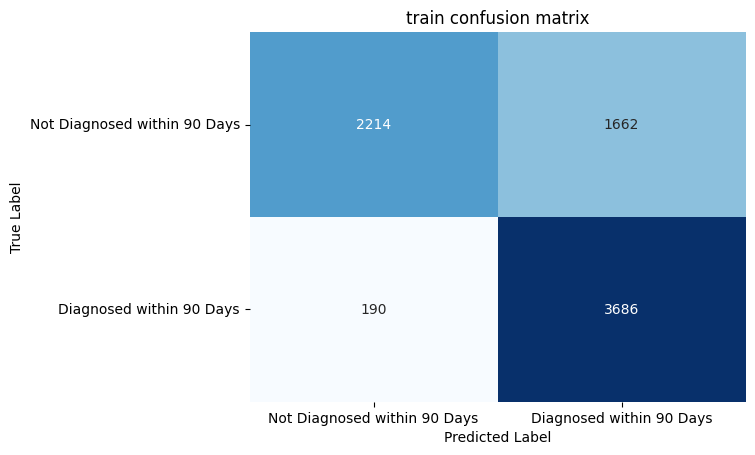

In [36]:
# calculate the confusion matrix
train_cm = tf.math.confusion_matrix(train_y, train_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(train_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('train confusion matrix')
plt.show()

In [37]:
# predict using the training set
val_yhat_probs = model.predict(val_x)
# Assuming a threshold of 0.5 for classification
val_yhat_result = (val_yhat_probs > 0.5).astype(int)
val_yhat_result

81/81 [==============================] - 0s 1ms/step


array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [38]:
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.metrics import fbeta_score

# Assuming train_y and train_yhat_result are defined
classes = ["Not Diagnosed within 90 Days", "Diagnosed within 90 Days"]

# Print classification report
print('\nTraining Classification Report\n')
print(classification_report(val_y, val_yhat_result, target_names=classes))

# Calculate and print F2 score
# Note: beta > 1 favors recall (beta = 2.0 in this case)
f2_score = fbeta_score(val_y, val_yhat_result, beta=2, average='binary')
print("F2 Score: {:.2f}".format(f2_score))



Training Classification Report

                              precision    recall  f1-score   support

Not Diagnosed within 90 Days       0.86      0.56      0.68       970
    Diagnosed within 90 Days       0.78      0.95      0.86      1612

                    accuracy                           0.80      2582
                   macro avg       0.82      0.75      0.77      2582
                weighted avg       0.81      0.80      0.79      2582

F2 Score: 0.91


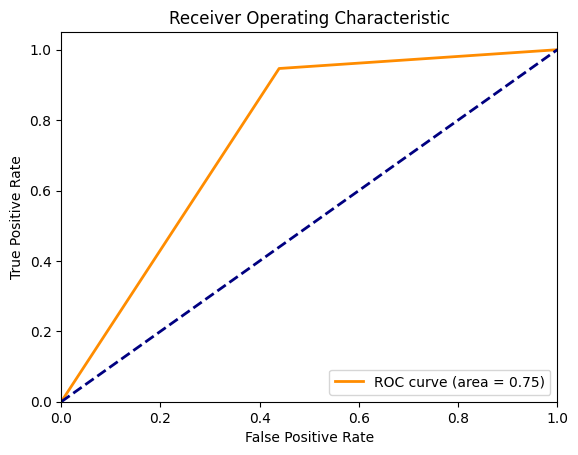

In [39]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have y_true and y_scores from your validation set
y_true = val_y
y_scores = val_yhat_result

# Calculate ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


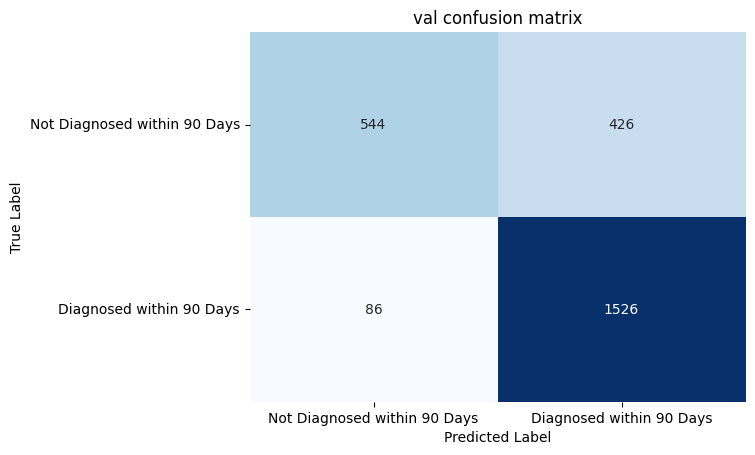

In [40]:
# calculate the confusion matrix
val_cm = tf.math.confusion_matrix(val_y, val_yhat_result)

# use a heatmap to display the confusion matrix
ax = sns.heatmap(val_cm,
                 annot=True,
                 fmt='.0f',
                 cmap='Blues',
                 xticklabels=classes,
                 yticklabels=classes,
                 cbar=False)

# add axis labels
ax.set(xlabel='Predicted Label',ylabel='True Label')
plt.title('val confusion matrix')
plt.show()